<a href="https://colab.research.google.com/github/jakartaresearch/adi-buzzer/blob/dev/notebook/R36_BPE_DL_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil --q
!pip install psutil --q
!pip install humanize --q

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]

def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.7 GB  | Proc size: 112.3 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [2]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive/"     # default location for the drive
drive.mount(ROOT)           # we mount the google drive at /content/drive

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!pip install bpemb

In [4]:
workdir_path = 'drive/My Drive/jakarta research/adi-buzzer/'

In [5]:
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from bpemb import BPEmb
from torch import tensor
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence

% matplotlib inline
pd.set_option('precision', 2)

from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

## Prepare dataset and model

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [7]:
def load_data(path):
    data = pd.read_csv(path, keep_default_na=False)
    return data

def prepare_dataset(dataset_pth):
    dataset = load_data(dataset_pth)

    X, X_test, y, y_test = train_test_split(dataset.drop(['buzzer'], axis=1), dataset.buzzer, test_size=0.2, 
                                            random_state=123, stratify=dataset.buzzer)
    X_test.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
    test = (X_test, y_test)

    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    data = (X, y)
    return data, test

In [8]:
class DatasetBuzzer(Dataset):
    def __init__(self, data, bpe):
        feat, label = data
        feat.reset_index(drop=True, inplace=True)
        label.reset_index(drop=True, inplace=True)

        self.feat = feat
        self.label = label
        self.bpe = bpe
        
    def __getitem__(self, idx):
        x_raw = self.feat.loc[idx, 'text_used']
        y  = self.label[idx]
        
        x = self.bpe.encode_ids(x_raw)
        x = tensor(x)
        y = torch.LongTensor([y])
        
        return (x, y)
    
    def __len__(self):
        return len(self.feat)

In [9]:
def padding(data):
    x_list = []
    y_list = []
    for x, y in data:
        x_list.append(x)
        y_list.append(y)
        
    x_pad = pad_sequence(x_list, batch_first=True)
    y_pad = pad_sequence(y_list, batch_first=True)
    
    return x_pad, y_pad

In [10]:
class LSTM(nn.Module):
    def __init__(self, hidden_size, num_class, weights):
        super(LSTM, self).__init__()
        self.word_embeddings = nn.Embedding.from_pretrained(weights)
        self.lstm = nn.LSTM(weights.shape[1], hidden_size, num_layers=1, dropout=0.7, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size, num_class)
        
    def forward(self, input_):
        input_ = self.word_embeddings(input_)
        out, (hidden_state, cell_state) = self.lstm(input_)
        out = self.fc(hidden_state[-1])

        return out

## Preparation data, Load BPE embeddings

In [11]:
bpe = BPEmb(lang="id", vs=100000, dim=300)

In [12]:
dataset_pth = workdir_path+'dataset/dataset.csv'
data, test = prepare_dataset(dataset_pth)

In [13]:
test_dataset = DatasetBuzzer(test, bpe)
test_dataloader = DataLoader(test_dataset, batch_size=32, collate_fn=padding)

## Hyperparameter and BPE Embeddings

In [14]:
weights = tensor(bpe.vectors)
hidden_size = 128
num_class = 2
b_size = 32
epochs = 15

## Setup Model

In [15]:
model = LSTM(hidden_size, num_class, weights)
model.to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


LSTM(
  (word_embeddings): Embedding(100000, 300)
  (lstm): LSTM(300, 128, batch_first=True, dropout=0.7, bidirectional=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [16]:
parameters = sum(p.numel() for p in model.parameters())
print(f'model has {parameters:,} trainable parameters')

model has 30,440,578 trainable parameters


## Setup Optimizer and Loss function

In [17]:
optimizer = optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss()

## Training and Validation model

In [18]:
def scoring(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return acc, pre, rec, f1

In [19]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [20]:
def train_model(model, dataloader):
    running_train_loss = 0
    running_train_acc = 0
    running_train_pre = 0
    running_train_rec = 0
    running_train_f1 = 0
    
    ## Training mode
    n_batch = len(dataloader)
    t0 = time.time()
    model.train()
    for idx, (x, y) in tqdm(enumerate(dataloader, 1)):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.squeeze().to(device)
        
        y_pred = model(x)
        loss = criterion(y_pred, y)
        
        y = y.cpu().numpy()
        y_pred = torch.max(y_pred, 1)[1].cpu().detach().numpy()
        acc, pre, rec, f1 = scoring(y, y_pred)

        running_train_loss += loss.item() * x.size(0)
        running_train_acc += acc
        running_train_pre += pre
        running_train_rec += rec
        running_train_f1 += f1

        loss.backward()
        optimizer.step()

    epoch_train_loss = running_train_loss / len(dataloader.dataset)
    epoch_train_acc = running_train_acc / n_batch
    epoch_train_pre = running_train_pre / n_batch
    epoch_train_rec = running_train_rec / n_batch
    epoch_train_f1 = running_train_f1 / n_batch
    
    train_time = time.time() - t0
    return epoch_train_loss, epoch_train_acc, epoch_train_pre, epoch_train_rec, epoch_train_f1, train_time

In [21]:
def eval_model(model, dataloader):
    running_val_loss = 0
    running_val_acc = 0
    running_val_pre = 0
    running_val_rec = 0
    running_val_f1 = 0
    
    ## Validation mode
    n_batch = len(dataloader)
    t0 = time.time()
    model.eval()
    with torch.no_grad():
        for idx, (x, y) in tqdm(enumerate(dataloader, 1)):
            x = x.to(device)
            y = y.squeeze().to(device)

            y_pred = model(x)
            loss = criterion(y_pred, y)
            
            y = y.cpu().numpy()
            y_pred = torch.max(y_pred, 1)[1].cpu().detach().numpy()
            acc, pre, rec, f1 = scoring(y, y_pred)

            running_val_loss += loss.item() * x.size(0)
            running_val_acc += acc
            running_val_pre += pre
            running_val_rec += rec
            running_val_f1 += f1
            
    epoch_val_loss = running_val_loss / len(dataloader.dataset)
    epoch_val_acc = running_val_acc / n_batch
    epoch_val_pre = running_val_pre / n_batch
    epoch_val_rec = running_val_rec / n_batch
    epoch_val_f1 = running_val_f1 / n_batch
    
    val_time = time.time() - t0
    return epoch_val_loss, epoch_val_acc, epoch_val_pre, epoch_val_rec, epoch_val_f1, val_time

## Learning routine

### Preparation KFold data

In [22]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=123)
data_gen = rskf.split(data[0], data[1])

### RUN !!!

In [23]:
kfold_stats = []
total_t0 = time.time()

for idx, (train_idx, val_idx) in enumerate(data_gen, 1):
    print(f'\n==== KFold {idx} / 5 ====')

    train = (data[0].iloc[train_idx, :], data[1][train_idx])
    val = (data[0].iloc[val_idx, :], data[1][val_idx])

    train_dataset = DatasetBuzzer(train, bpe)
    val_dataset = DatasetBuzzer(val, bpe)
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=b_size, collate_fn=padding)
    val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=b_size, collate_fn=padding)

    model = LSTM(hidden_size, num_class, weights)
    model.to(device)
    optimizer = optim.AdamW(model.parameters())
    criterion = nn.CrossEntropyLoss()

    training_stats = []
    for epoch_i in range(0, epochs):
        print(f'\n==== Epoch {epoch_i+1} / {epochs} ====')
        epoch_train_loss, epoch_train_acc, epoch_train_pre, epoch_train_rec, epoch_train_f1, train_time = train_model(model, train_dataloader)
        epoch_val_loss, epoch_val_acc, epoch_val_pre, epoch_val_rec, epoch_val_f1, val_time = eval_model(model, val_dataloader)

        training_stats.append({'Epoch': epoch_i + 1,
                              'Training Loss': epoch_train_loss,
                              'Validation Loss': epoch_val_loss,
                              'Training Accuracy': epoch_train_acc,
                              'Validation Accuracy': epoch_val_acc,
                              'Training Precision': epoch_train_pre,
                              'Validation Precision': epoch_val_pre,
                              'Training Recall': epoch_train_rec,
                              'Validation Recall': epoch_val_rec,
                              'Training F1': epoch_train_f1,
                              'Validation F1': epoch_val_f1
                              })

        print("\nTRAINING")
        print(f"Loss: {epoch_train_loss:.2f}  |  Accuracy: {epoch_train_acc:.2f}")
        print(f"Precision: {epoch_train_pre:.2f}  |  Recall: {epoch_train_rec:.2f}  |  F1: {epoch_train_f1:.2f}")
        print(f"Exec Time: {round(train_time)}s")
        print("\nEVALUATING")
        print(f"Loss: {epoch_val_loss:.2f}  |  Accuracy: {epoch_val_acc:.2f}")
        print(f"Precision: {epoch_val_pre:.2f}  |  Recall: {epoch_val_rec:.2f}  |  F1: {epoch_val_f1:.2f}")
        print(f"Exec Time: {round(val_time)}s")
    
    kfold_stats.append(training_stats)

print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
0it [00:00, ?it/s]


==== KFold 1 / 5 ====

==== Epoch 1 / 15 ====


60it [00:17,  3.53it/s]
15it [00:02,  5.94it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.52  |  Accuracy: 0.77
Precision: 0.22  |  Recall: 0.08  |  F1: 0.09
Exec Time: 17s

EVALUATING
Loss: 0.45  |  Accuracy: 0.79
Precision: 0.38  |  Recall: 0.12  |  F1: 0.17
Exec Time: 3s

==== Epoch 2 / 15 ====


60it [00:17,  3.39it/s]
15it [00:02,  5.82it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.45  |  Accuracy: 0.82
Precision: 0.62  |  Recall: 0.28  |  F1: 0.36
Exec Time: 18s

EVALUATING
Loss: 0.48  |  Accuracy: 0.80
Precision: 0.61  |  Recall: 0.30  |  F1: 0.38
Exec Time: 3s

==== Epoch 3 / 15 ====


60it [00:17,  3.39it/s]
15it [00:02,  6.00it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.38  |  Accuracy: 0.84
Precision: 0.73  |  Recall: 0.48  |  F1: 0.54
Exec Time: 18s

EVALUATING
Loss: 0.43  |  Accuracy: 0.81
Precision: 0.58  |  Recall: 0.42  |  F1: 0.46
Exec Time: 2s

==== Epoch 4 / 15 ====


60it [00:17,  3.48it/s]
15it [00:02,  5.96it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.36  |  Accuracy: 0.85
Precision: 0.68  |  Recall: 0.60  |  F1: 0.61
Exec Time: 17s

EVALUATING
Loss: 0.44  |  Accuracy: 0.81
Precision: 0.58  |  Recall: 0.46  |  F1: 0.50
Exec Time: 3s

==== Epoch 5 / 15 ====


60it [00:17,  3.51it/s]
15it [00:02,  6.00it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.32  |  Accuracy: 0.87
Precision: 0.75  |  Recall: 0.61  |  F1: 0.63
Exec Time: 17s

EVALUATING
Loss: 0.51  |  Accuracy: 0.81
Precision: 0.60  |  Recall: 0.38  |  F1: 0.44
Exec Time: 3s

==== Epoch 6 / 15 ====


60it [00:17,  3.49it/s]
15it [00:02,  6.12it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.27  |  Accuracy: 0.89
Precision: 0.80  |  Recall: 0.66  |  F1: 0.70
Exec Time: 17s

EVALUATING
Loss: 0.49  |  Accuracy: 0.79
Precision: 0.56  |  Recall: 0.31  |  F1: 0.37
Exec Time: 2s

==== Epoch 7 / 15 ====


60it [00:17,  3.48it/s]
15it [00:02,  6.11it/s]
1it [00:00,  6.27it/s]


TRAINING
Loss: 0.25  |  Accuracy: 0.91
Precision: 0.88  |  Recall: 0.69  |  F1: 0.75
Exec Time: 17s

EVALUATING
Loss: 0.48  |  Accuracy: 0.81
Precision: 0.60  |  Recall: 0.45  |  F1: 0.48
Exec Time: 2s

==== Epoch 8 / 15 ====


60it [00:17,  3.46it/s]
15it [00:02,  6.11it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.21  |  Accuracy: 0.93
Precision: 0.86  |  Recall: 0.82  |  F1: 0.83
Exec Time: 17s

EVALUATING
Loss: 0.52  |  Accuracy: 0.78
Precision: 0.50  |  Recall: 0.34  |  F1: 0.39
Exec Time: 2s

==== Epoch 9 / 15 ====


60it [00:17,  3.51it/s]
15it [00:02,  6.19it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.14  |  Accuracy: 0.95
Precision: 0.91  |  Recall: 0.84  |  F1: 0.87
Exec Time: 17s

EVALUATING
Loss: 0.68  |  Accuracy: 0.80
Precision: 0.59  |  Recall: 0.29  |  F1: 0.36
Exec Time: 2s

==== Epoch 10 / 15 ====


60it [00:17,  3.46it/s]
15it [00:02,  6.13it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.11  |  Accuracy: 0.97
Precision: 0.94  |  Recall: 0.87  |  F1: 0.90
Exec Time: 17s

EVALUATING
Loss: 0.75  |  Accuracy: 0.79
Precision: 0.55  |  Recall: 0.36  |  F1: 0.41
Exec Time: 2s

==== Epoch 11 / 15 ====


60it [00:17,  3.48it/s]
15it [00:02,  5.88it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.07  |  Accuracy: 0.98
Precision: 0.98  |  Recall: 0.91  |  F1: 0.94
Exec Time: 17s

EVALUATING
Loss: 0.72  |  Accuracy: 0.76
Precision: 0.46  |  Recall: 0.44  |  F1: 0.43
Exec Time: 3s

==== Epoch 12 / 15 ====


60it [00:17,  3.45it/s]
15it [00:02,  6.09it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.07  |  Accuracy: 0.98
Precision: 0.94  |  Recall: 0.92  |  F1: 0.92
Exec Time: 17s

EVALUATING
Loss: 0.79  |  Accuracy: 0.79
Precision: 0.55  |  Recall: 0.40  |  F1: 0.44
Exec Time: 2s

==== Epoch 13 / 15 ====


60it [00:16,  3.56it/s]
15it [00:02,  5.67it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.02  |  Accuracy: 0.99
Precision: 1.00  |  Recall: 0.98  |  F1: 0.99
Exec Time: 17s

EVALUATING
Loss: 0.91  |  Accuracy: 0.79
Precision: 0.55  |  Recall: 0.52  |  F1: 0.51
Exec Time: 3s

==== Epoch 14 / 15 ====


60it [00:17,  3.50it/s]
15it [00:02,  6.14it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.01  |  Accuracy: 1.00
Precision: 1.00  |  Recall: 1.00  |  F1: 1.00
Exec Time: 17s

EVALUATING
Loss: 0.99  |  Accuracy: 0.80
Precision: 0.54  |  Recall: 0.37  |  F1: 0.43
Exec Time: 2s

==== Epoch 15 / 15 ====


60it [00:17,  3.44it/s]
15it [00:02,  5.71it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.01  |  Accuracy: 1.00
Precision: 1.00  |  Recall: 0.99  |  F1: 0.99
Exec Time: 17s

EVALUATING
Loss: 1.02  |  Accuracy: 0.80
Precision: 0.53  |  Recall: 0.42  |  F1: 0.44
Exec Time: 3s

==== KFold 2 / 5 ====

==== Epoch 1 / 15 ====


60it [00:17,  3.45it/s]
15it [00:02,  5.83it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.52  |  Accuracy: 0.76
Precision: 0.20  |  Recall: 0.06  |  F1: 0.07
Exec Time: 17s

EVALUATING
Loss: 0.46  |  Accuracy: 0.78
Precision: 0.44  |  Recall: 0.18  |  F1: 0.24
Exec Time: 3s

==== Epoch 2 / 15 ====


60it [00:17,  3.41it/s]
15it [00:02,  5.80it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.41  |  Accuracy: 0.83
Precision: 0.66  |  Recall: 0.35  |  F1: 0.43
Exec Time: 18s

EVALUATING
Loss: 0.42  |  Accuracy: 0.79
Precision: 0.55  |  Recall: 0.45  |  F1: 0.48
Exec Time: 3s

==== Epoch 3 / 15 ====


60it [00:17,  3.51it/s]
15it [00:02,  5.46it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.36  |  Accuracy: 0.85
Precision: 0.67  |  Recall: 0.55  |  F1: 0.59
Exec Time: 17s

EVALUATING
Loss: 0.47  |  Accuracy: 0.81
Precision: 0.66  |  Recall: 0.31  |  F1: 0.41
Exec Time: 3s

==== Epoch 4 / 15 ====


60it [00:16,  3.58it/s]
15it [00:02,  5.75it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.33  |  Accuracy: 0.86
Precision: 0.76  |  Recall: 0.57  |  F1: 0.62
Exec Time: 17s

EVALUATING
Loss: 0.42  |  Accuracy: 0.82
Precision: 0.60  |  Recall: 0.49  |  F1: 0.53
Exec Time: 3s

==== Epoch 5 / 15 ====


60it [00:17,  3.50it/s]
15it [00:02,  5.88it/s]
1it [00:00,  5.53it/s]


TRAINING
Loss: 0.29  |  Accuracy: 0.90
Precision: 0.82  |  Recall: 0.69  |  F1: 0.72
Exec Time: 17s

EVALUATING
Loss: 0.45  |  Accuracy: 0.81
Precision: 0.60  |  Recall: 0.47  |  F1: 0.50
Exec Time: 3s

==== Epoch 6 / 15 ====


60it [00:16,  3.57it/s]
15it [00:02,  5.86it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.23  |  Accuracy: 0.92
Precision: 0.87  |  Recall: 0.75  |  F1: 0.79
Exec Time: 17s

EVALUATING
Loss: 0.56  |  Accuracy: 0.79
Precision: 0.57  |  Recall: 0.35  |  F1: 0.40
Exec Time: 3s

==== Epoch 7 / 15 ====


60it [00:17,  3.46it/s]
15it [00:02,  5.68it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.16  |  Accuracy: 0.94
Precision: 0.93  |  Recall: 0.83  |  F1: 0.86
Exec Time: 17s

EVALUATING
Loss: 0.56  |  Accuracy: 0.81
Precision: 0.57  |  Recall: 0.41  |  F1: 0.47
Exec Time: 3s

==== Epoch 8 / 15 ====


60it [00:17,  3.53it/s]
15it [00:02,  5.61it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.11  |  Accuracy: 0.96
Precision: 0.96  |  Recall: 0.88  |  F1: 0.91
Exec Time: 17s

EVALUATING
Loss: 0.63  |  Accuracy: 0.82
Precision: 0.58  |  Recall: 0.63  |  F1: 0.60
Exec Time: 3s

==== Epoch 9 / 15 ====


60it [00:17,  3.49it/s]
15it [00:02,  5.93it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.08  |  Accuracy: 0.98
Precision: 0.97  |  Recall: 0.93  |  F1: 0.94
Exec Time: 17s

EVALUATING
Loss: 0.68  |  Accuracy: 0.81
Precision: 0.56  |  Recall: 0.51  |  F1: 0.51
Exec Time: 3s

==== Epoch 10 / 15 ====


60it [00:16,  3.54it/s]
15it [00:02,  5.83it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.04  |  Accuracy: 0.99
Precision: 0.98  |  Recall: 0.96  |  F1: 0.97
Exec Time: 17s

EVALUATING
Loss: 0.78  |  Accuracy: 0.78
Precision: 0.50  |  Recall: 0.50  |  F1: 0.48
Exec Time: 3s

==== Epoch 11 / 15 ====


60it [00:16,  3.55it/s]
15it [00:02,  5.75it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.03  |  Accuracy: 0.99
Precision: 0.99  |  Recall: 0.99  |  F1: 0.99
Exec Time: 17s

EVALUATING
Loss: 0.76  |  Accuracy: 0.81
Precision: 0.57  |  Recall: 0.47  |  F1: 0.49
Exec Time: 3s

==== Epoch 12 / 15 ====


60it [00:17,  3.50it/s]
15it [00:02,  5.78it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.02  |  Accuracy: 0.99
Precision: 0.99  |  Recall: 0.99  |  F1: 0.99
Exec Time: 17s

EVALUATING
Loss: 0.90  |  Accuracy: 0.81
Precision: 0.62  |  Recall: 0.43  |  F1: 0.47
Exec Time: 3s

==== Epoch 13 / 15 ====


60it [00:17,  3.47it/s]
15it [00:02,  5.59it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.01  |  Accuracy: 1.00
Precision: 1.00  |  Recall: 1.00  |  F1: 1.00
Exec Time: 17s

EVALUATING
Loss: 0.96  |  Accuracy: 0.78
Precision: 0.51  |  Recall: 0.43  |  F1: 0.45
Exec Time: 3s

==== Epoch 14 / 15 ====


60it [00:17,  3.50it/s]
15it [00:02,  5.79it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.02  |  Accuracy: 0.99
Precision: 0.98  |  Recall: 0.98  |  F1: 0.98
Exec Time: 17s

EVALUATING
Loss: 0.90  |  Accuracy: 0.79
Precision: 0.58  |  Recall: 0.41  |  F1: 0.47
Exec Time: 3s

==== Epoch 15 / 15 ====


60it [00:17,  3.49it/s]
15it [00:02,  5.91it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.02  |  Accuracy: 1.00
Precision: 0.99  |  Recall: 0.99  |  F1: 0.99
Exec Time: 17s

EVALUATING
Loss: 1.01  |  Accuracy: 0.79
Precision: 0.50  |  Recall: 0.59  |  F1: 0.52
Exec Time: 3s

==== KFold 3 / 5 ====

==== Epoch 1 / 15 ====


60it [00:16,  3.71it/s]
15it [00:03,  4.79it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.51  |  Accuracy: 0.78
Precision: 0.25  |  Recall: 0.09  |  F1: 0.11
Exec Time: 16s

EVALUATING
Loss: 0.46  |  Accuracy: 0.80
Precision: 0.62  |  Recall: 0.16  |  F1: 0.24
Exec Time: 3s

==== Epoch 2 / 15 ====


60it [00:16,  3.70it/s]
15it [00:03,  4.89it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.41  |  Accuracy: 0.83
Precision: 0.67  |  Recall: 0.36  |  F1: 0.44
Exec Time: 16s

EVALUATING
Loss: 0.44  |  Accuracy: 0.82
Precision: 0.60  |  Recall: 0.41  |  F1: 0.45
Exec Time: 3s

==== Epoch 3 / 15 ====


60it [00:16,  3.71it/s]
15it [00:03,  4.87it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.37  |  Accuracy: 0.84
Precision: 0.70  |  Recall: 0.41  |  F1: 0.47
Exec Time: 16s

EVALUATING
Loss: 0.45  |  Accuracy: 0.82
Precision: 0.65  |  Recall: 0.41  |  F1: 0.49
Exec Time: 3s

==== Epoch 4 / 15 ====


60it [00:16,  3.74it/s]
15it [00:03,  4.99it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.34  |  Accuracy: 0.86
Precision: 0.73  |  Recall: 0.60  |  F1: 0.64
Exec Time: 16s

EVALUATING
Loss: 0.43  |  Accuracy: 0.82
Precision: 0.61  |  Recall: 0.47  |  F1: 0.52
Exec Time: 3s

==== Epoch 5 / 15 ====


60it [00:15,  3.76it/s]
15it [00:03,  4.99it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.30  |  Accuracy: 0.88
Precision: 0.76  |  Recall: 0.65  |  F1: 0.68
Exec Time: 16s

EVALUATING
Loss: 0.49  |  Accuracy: 0.79
Precision: 0.54  |  Recall: 0.52  |  F1: 0.50
Exec Time: 3s

==== Epoch 6 / 15 ====


60it [00:16,  3.66it/s]
15it [00:03,  4.89it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.26  |  Accuracy: 0.91
Precision: 0.84  |  Recall: 0.72  |  F1: 0.75
Exec Time: 16s

EVALUATING
Loss: 0.50  |  Accuracy: 0.82
Precision: 0.59  |  Recall: 0.43  |  F1: 0.48
Exec Time: 3s

==== Epoch 7 / 15 ====


60it [00:16,  3.64it/s]
15it [00:03,  4.96it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.21  |  Accuracy: 0.92
Precision: 0.87  |  Recall: 0.72  |  F1: 0.77
Exec Time: 16s

EVALUATING
Loss: 0.52  |  Accuracy: 0.79
Precision: 0.54  |  Recall: 0.50  |  F1: 0.49
Exec Time: 3s

==== Epoch 8 / 15 ====


60it [00:15,  3.75it/s]
15it [00:03,  4.92it/s]
1it [00:00,  5.27it/s]


TRAINING
Loss: 0.14  |  Accuracy: 0.95
Precision: 0.94  |  Recall: 0.85  |  F1: 0.88
Exec Time: 16s

EVALUATING
Loss: 0.56  |  Accuracy: 0.79
Precision: 0.53  |  Recall: 0.50  |  F1: 0.50
Exec Time: 3s

==== Epoch 9 / 15 ====


60it [00:16,  3.73it/s]
15it [00:03,  4.87it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.10  |  Accuracy: 0.97
Precision: 0.97  |  Recall: 0.89  |  F1: 0.92
Exec Time: 16s

EVALUATING
Loss: 0.66  |  Accuracy: 0.79
Precision: 0.51  |  Recall: 0.45  |  F1: 0.47
Exec Time: 3s

==== Epoch 10 / 15 ====


60it [00:16,  3.70it/s]
15it [00:03,  4.96it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.08  |  Accuracy: 0.98
Precision: 0.97  |  Recall: 0.94  |  F1: 0.95
Exec Time: 16s

EVALUATING
Loss: 0.74  |  Accuracy: 0.81
Precision: 0.59  |  Recall: 0.39  |  F1: 0.46
Exec Time: 3s

==== Epoch 11 / 15 ====


60it [00:16,  3.68it/s]
15it [00:03,  4.96it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.05  |  Accuracy: 0.98
Precision: 0.98  |  Recall: 0.96  |  F1: 0.96
Exec Time: 16s

EVALUATING
Loss: 0.71  |  Accuracy: 0.80
Precision: 0.61  |  Recall: 0.44  |  F1: 0.49
Exec Time: 3s

==== Epoch 12 / 15 ====


60it [00:16,  3.67it/s]
15it [00:02,  5.10it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.04  |  Accuracy: 0.99
Precision: 0.96  |  Recall: 0.95  |  F1: 0.95
Exec Time: 16s

EVALUATING
Loss: 0.82  |  Accuracy: 0.80
Precision: 0.58  |  Recall: 0.50  |  F1: 0.52
Exec Time: 3s

==== Epoch 13 / 15 ====


60it [00:16,  3.67it/s]
15it [00:02,  5.07it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.02  |  Accuracy: 1.00
Precision: 1.00  |  Recall: 0.99  |  F1: 0.99
Exec Time: 16s

EVALUATING
Loss: 0.92  |  Accuracy: 0.81
Precision: 0.58  |  Recall: 0.45  |  F1: 0.49
Exec Time: 3s

==== Epoch 14 / 15 ====


60it [00:16,  3.74it/s]
15it [00:02,  5.03it/s]
1it [00:00,  5.04it/s]


TRAINING
Loss: 0.01  |  Accuracy: 1.00
Precision: 0.98  |  Recall: 0.98  |  F1: 0.98
Exec Time: 16s

EVALUATING
Loss: 1.01  |  Accuracy: 0.80
Precision: 0.57  |  Recall: 0.52  |  F1: 0.53
Exec Time: 3s

==== Epoch 15 / 15 ====


60it [00:16,  3.64it/s]
15it [00:03,  4.95it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.01  |  Accuracy: 1.00
Precision: 1.00  |  Recall: 1.00  |  F1: 1.00
Exec Time: 17s

EVALUATING
Loss: 1.08  |  Accuracy: 0.81
Precision: 0.57  |  Recall: 0.48  |  F1: 0.49
Exec Time: 3s

==== KFold 4 / 5 ====

==== Epoch 1 / 15 ====


60it [00:17,  3.52it/s]
15it [00:02,  5.79it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.51  |  Accuracy: 0.78
Precision: 0.22  |  Recall: 0.06  |  F1: 0.08
Exec Time: 17s

EVALUATING
Loss: 0.51  |  Accuracy: 0.80
Precision: 0.51  |  Recall: 0.28  |  F1: 0.35
Exec Time: 3s

==== Epoch 2 / 15 ====


60it [00:17,  3.50it/s]
15it [00:02,  5.71it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.42  |  Accuracy: 0.82
Precision: 0.68  |  Recall: 0.42  |  F1: 0.47
Exec Time: 17s

EVALUATING
Loss: 0.40  |  Accuracy: 0.82
Precision: 0.59  |  Recall: 0.59  |  F1: 0.58
Exec Time: 3s

==== Epoch 3 / 15 ====


60it [00:17,  3.48it/s]
15it [00:02,  6.03it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.45  |  Accuracy: 0.81
Precision: 0.40  |  Recall: 0.35  |  F1: 0.35
Exec Time: 17s

EVALUATING
Loss: 0.50  |  Accuracy: 0.78
Precision: 0.20  |  Recall: 0.03  |  F1: 0.04
Exec Time: 2s

==== Epoch 4 / 15 ====


60it [00:17,  3.47it/s]
15it [00:02,  6.01it/s]
1it [00:00,  6.27it/s]


TRAINING
Loss: 0.39  |  Accuracy: 0.83
Precision: 0.63  |  Recall: 0.45  |  F1: 0.49
Exec Time: 17s

EVALUATING
Loss: 0.41  |  Accuracy: 0.83
Precision: 0.72  |  Recall: 0.45  |  F1: 0.52
Exec Time: 3s

==== Epoch 5 / 15 ====


60it [00:17,  3.53it/s]
15it [00:02,  5.89it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.32  |  Accuracy: 0.86
Precision: 0.73  |  Recall: 0.62  |  F1: 0.64
Exec Time: 17s

EVALUATING
Loss: 0.41  |  Accuracy: 0.82
Precision: 0.55  |  Recall: 0.50  |  F1: 0.50
Exec Time: 3s

==== Epoch 6 / 15 ====


60it [00:16,  3.56it/s]
15it [00:02,  6.05it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.29  |  Accuracy: 0.89
Precision: 0.81  |  Recall: 0.69  |  F1: 0.72
Exec Time: 17s

EVALUATING
Loss: 0.44  |  Accuracy: 0.84
Precision: 0.76  |  Recall: 0.39  |  F1: 0.46
Exec Time: 2s

==== Epoch 7 / 15 ====


60it [00:16,  3.54it/s]
15it [00:02,  5.88it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.27  |  Accuracy: 0.90
Precision: 0.84  |  Recall: 0.65  |  F1: 0.72
Exec Time: 17s

EVALUATING
Loss: 0.44  |  Accuracy: 0.81
Precision: 0.59  |  Recall: 0.59  |  F1: 0.57
Exec Time: 3s

==== Epoch 8 / 15 ====


60it [00:17,  3.43it/s]
15it [00:02,  6.08it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.22  |  Accuracy: 0.92
Precision: 0.87  |  Recall: 0.73  |  F1: 0.78
Exec Time: 17s

EVALUATING
Loss: 0.46  |  Accuracy: 0.80
Precision: 0.55  |  Recall: 0.41  |  F1: 0.43
Exec Time: 2s

==== Epoch 9 / 15 ====


60it [00:16,  3.53it/s]
15it [00:02,  5.95it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.18  |  Accuracy: 0.93
Precision: 0.91  |  Recall: 0.79  |  F1: 0.83
Exec Time: 17s

EVALUATING
Loss: 0.52  |  Accuracy: 0.77
Precision: 0.51  |  Recall: 0.47  |  F1: 0.46
Exec Time: 3s

==== Epoch 10 / 15 ====


60it [00:17,  3.50it/s]
15it [00:02,  6.02it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.12  |  Accuracy: 0.96
Precision: 0.95  |  Recall: 0.87  |  F1: 0.90
Exec Time: 17s

EVALUATING
Loss: 0.53  |  Accuracy: 0.79
Precision: 0.52  |  Recall: 0.39  |  F1: 0.43
Exec Time: 2s

==== Epoch 11 / 15 ====


60it [00:17,  3.49it/s]
15it [00:02,  5.95it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.07  |  Accuracy: 0.98
Precision: 0.98  |  Recall: 0.94  |  F1: 0.96
Exec Time: 17s

EVALUATING
Loss: 0.60  |  Accuracy: 0.79
Precision: 0.53  |  Recall: 0.44  |  F1: 0.48
Exec Time: 3s

==== Epoch 12 / 15 ====


60it [00:17,  3.53it/s]
15it [00:02,  6.03it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.06  |  Accuracy: 0.98
Precision: 0.95  |  Recall: 0.94  |  F1: 0.94
Exec Time: 17s

EVALUATING
Loss: 0.68  |  Accuracy: 0.81
Precision: 0.63  |  Recall: 0.41  |  F1: 0.47
Exec Time: 2s

==== Epoch 13 / 15 ====


60it [00:17,  3.46it/s]
15it [00:02,  6.02it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.03  |  Accuracy: 0.99
Precision: 0.98  |  Recall: 0.96  |  F1: 0.97
Exec Time: 17s

EVALUATING
Loss: 0.77  |  Accuracy: 0.80
Precision: 0.58  |  Recall: 0.47  |  F1: 0.50
Exec Time: 2s

==== Epoch 14 / 15 ====


60it [00:17,  3.50it/s]
15it [00:02,  5.96it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.02  |  Accuracy: 1.00
Precision: 0.99  |  Recall: 0.99  |  F1: 0.99
Exec Time: 17s

EVALUATING
Loss: 0.91  |  Accuracy: 0.78
Precision: 0.42  |  Recall: 0.24  |  F1: 0.30
Exec Time: 3s

==== Epoch 15 / 15 ====


60it [00:16,  3.55it/s]
15it [00:02,  5.95it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.07  |  Accuracy: 0.98
Precision: 0.95  |  Recall: 0.93  |  F1: 0.94
Exec Time: 17s

EVALUATING
Loss: 0.76  |  Accuracy: 0.82
Precision: 0.61  |  Recall: 0.44  |  F1: 0.49
Exec Time: 3s

==== KFold 5 / 5 ====

==== Epoch 1 / 15 ====


60it [00:17,  3.49it/s]
15it [00:02,  5.42it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.53  |  Accuracy: 0.78
Precision: 0.24  |  Recall: 0.05  |  F1: 0.06
Exec Time: 17s

EVALUATING
Loss: 0.45  |  Accuracy: 0.78
Precision: 0.47  |  Recall: 0.08  |  F1: 0.13
Exec Time: 3s

==== Epoch 2 / 15 ====


60it [00:16,  3.61it/s]
15it [00:02,  5.61it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.42  |  Accuracy: 0.82
Precision: 0.65  |  Recall: 0.31  |  F1: 0.39
Exec Time: 17s

EVALUATING
Loss: 0.45  |  Accuracy: 0.82
Precision: 0.69  |  Recall: 0.31  |  F1: 0.37
Exec Time: 3s

==== Epoch 3 / 15 ====


60it [00:16,  3.54it/s]
15it [00:02,  5.51it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.37  |  Accuracy: 0.84
Precision: 0.70  |  Recall: 0.52  |  F1: 0.57
Exec Time: 17s

EVALUATING
Loss: 0.38  |  Accuracy: 0.84
Precision: 0.61  |  Recall: 0.66  |  F1: 0.61
Exec Time: 3s

==== Epoch 4 / 15 ====


60it [00:16,  3.55it/s]
15it [00:02,  5.49it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.33  |  Accuracy: 0.86
Precision: 0.75  |  Recall: 0.58  |  F1: 0.62
Exec Time: 17s

EVALUATING
Loss: 0.39  |  Accuracy: 0.83
Precision: 0.61  |  Recall: 0.66  |  F1: 0.62
Exec Time: 3s

==== Epoch 5 / 15 ====


60it [00:17,  3.52it/s]
15it [00:02,  5.41it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.29  |  Accuracy: 0.89
Precision: 0.78  |  Recall: 0.69  |  F1: 0.71
Exec Time: 17s

EVALUATING
Loss: 0.42  |  Accuracy: 0.83
Precision: 0.60  |  Recall: 0.40  |  F1: 0.46
Exec Time: 3s

==== Epoch 6 / 15 ====


60it [00:16,  3.54it/s]
15it [00:02,  5.57it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.33  |  Accuracy: 0.86
Precision: 0.76  |  Recall: 0.62  |  F1: 0.63
Exec Time: 17s

EVALUATING
Loss: 0.49  |  Accuracy: 0.81
Precision: 0.60  |  Recall: 0.27  |  F1: 0.36
Exec Time: 3s

==== Epoch 7 / 15 ====


60it [00:16,  3.55it/s]
15it [00:02,  5.47it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.28  |  Accuracy: 0.89
Precision: 0.84  |  Recall: 0.62  |  F1: 0.69
Exec Time: 17s

EVALUATING
Loss: 0.43  |  Accuracy: 0.82
Precision: 0.61  |  Recall: 0.62  |  F1: 0.60
Exec Time: 3s

==== Epoch 8 / 15 ====


60it [00:16,  3.59it/s]
15it [00:02,  5.48it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.20  |  Accuracy: 0.93
Precision: 0.87  |  Recall: 0.77  |  F1: 0.80
Exec Time: 17s

EVALUATING
Loss: 0.47  |  Accuracy: 0.82
Precision: 0.63  |  Recall: 0.47  |  F1: 0.50
Exec Time: 3s

==== Epoch 9 / 15 ====


60it [00:16,  3.57it/s]
15it [00:02,  5.41it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.16  |  Accuracy: 0.95
Precision: 0.92  |  Recall: 0.84  |  F1: 0.86
Exec Time: 17s

EVALUATING
Loss: 0.55  |  Accuracy: 0.79
Precision: 0.52  |  Recall: 0.65  |  F1: 0.57
Exec Time: 3s

==== Epoch 10 / 15 ====


60it [00:16,  3.56it/s]
15it [00:02,  5.54it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.10  |  Accuracy: 0.97
Precision: 0.96  |  Recall: 0.92  |  F1: 0.93
Exec Time: 17s

EVALUATING
Loss: 0.58  |  Accuracy: 0.81
Precision: 0.54  |  Recall: 0.47  |  F1: 0.48
Exec Time: 3s

==== Epoch 11 / 15 ====


60it [00:16,  3.62it/s]
15it [00:02,  5.55it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.06  |  Accuracy: 0.98
Precision: 0.98  |  Recall: 0.95  |  F1: 0.96
Exec Time: 17s

EVALUATING
Loss: 0.67  |  Accuracy: 0.81
Precision: 0.57  |  Recall: 0.50  |  F1: 0.52
Exec Time: 3s

==== Epoch 12 / 15 ====


60it [00:16,  3.57it/s]
15it [00:02,  5.56it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.03  |  Accuracy: 1.00
Precision: 1.00  |  Recall: 0.98  |  F1: 0.99
Exec Time: 17s

EVALUATING
Loss: 0.75  |  Accuracy: 0.81
Precision: 0.55  |  Recall: 0.50  |  F1: 0.51
Exec Time: 3s

==== Epoch 13 / 15 ====


60it [00:16,  3.56it/s]
15it [00:02,  5.50it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.02  |  Accuracy: 1.00
Precision: 1.00  |  Recall: 0.99  |  F1: 0.99
Exec Time: 17s

EVALUATING
Loss: 0.81  |  Accuracy: 0.78
Precision: 0.50  |  Recall: 0.52  |  F1: 0.50
Exec Time: 3s

==== Epoch 14 / 15 ====


60it [00:16,  3.56it/s]
15it [00:02,  5.55it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.01  |  Accuracy: 1.00
Precision: 1.00  |  Recall: 1.00  |  F1: 1.00
Exec Time: 17s

EVALUATING
Loss: 0.87  |  Accuracy: 0.80
Precision: 0.49  |  Recall: 0.48  |  F1: 0.48
Exec Time: 3s

==== Epoch 15 / 15 ====


60it [00:16,  3.55it/s]
15it [00:02,  5.48it/s]


TRAINING
Loss: 0.01  |  Accuracy: 1.00
Precision: 1.00  |  Recall: 1.00  |  F1: 1.00
Exec Time: 17s

EVALUATING
Loss: 0.93  |  Accuracy: 0.79
Precision: 0.55  |  Recall: 0.53  |  F1: 0.51
Exec Time: 3s
Training complete!
Total training took 0:24:31 (h:mm:ss)


In [24]:
def df_stats(training_stats):
    # Create a DataFrame from our training statistics.
    df = pd.DataFrame(data=training_stats)
    # Use the 'epoch' as the row index.
    df = df.set_index('Epoch')
    return df

In [25]:
def plot_learning_curve(stats, train_metric, val_metric):
    sns.set(style='darkgrid')
    a = 2  # number of rows
    b = 3  # number of columns
    c = 1  # initialize plot counter

    fig = plt.figure(figsize=(16,10))

    for i in stats:
        plt.subplot(a, b, c)
        # Plot the learning curve.
        plt.plot(i[train_metric], 'b-o', label="Training")
        plt.plot(i[val_metric], 'g-o', label="Validation")
        plt.title(f"{train_metric} VS {val_metric}")
        plt.xlabel('Epoch')
        plt.legend()
        plt.xticks(np.arange(1, epochs))
        c = c + 1

    plt.show()

## Show

In [26]:
stats = []
for log_metric in kfold_stats:
    stats.append(df_stats(log_metric))

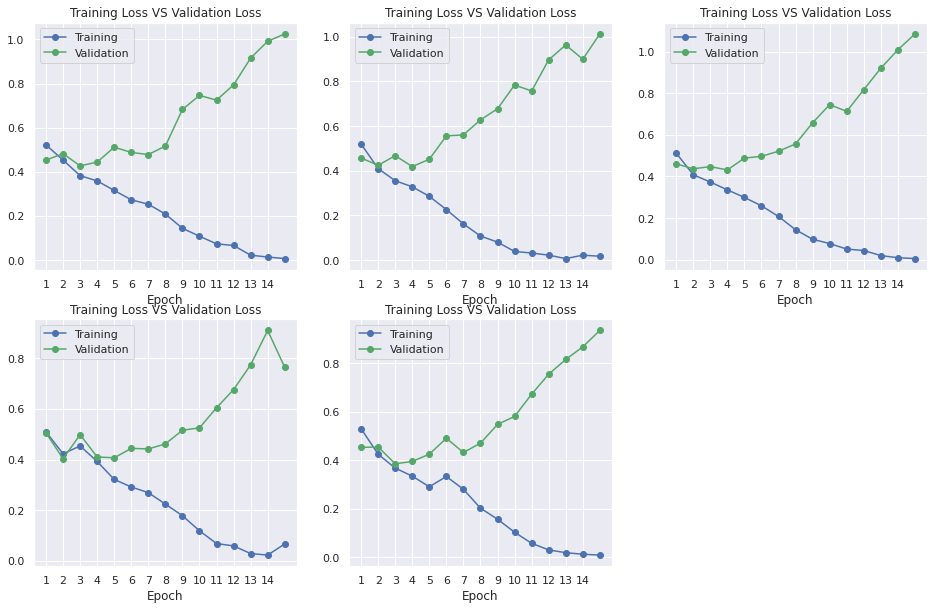

In [27]:
plot_learning_curve(stats, 'Training Loss', 'Validation Loss')

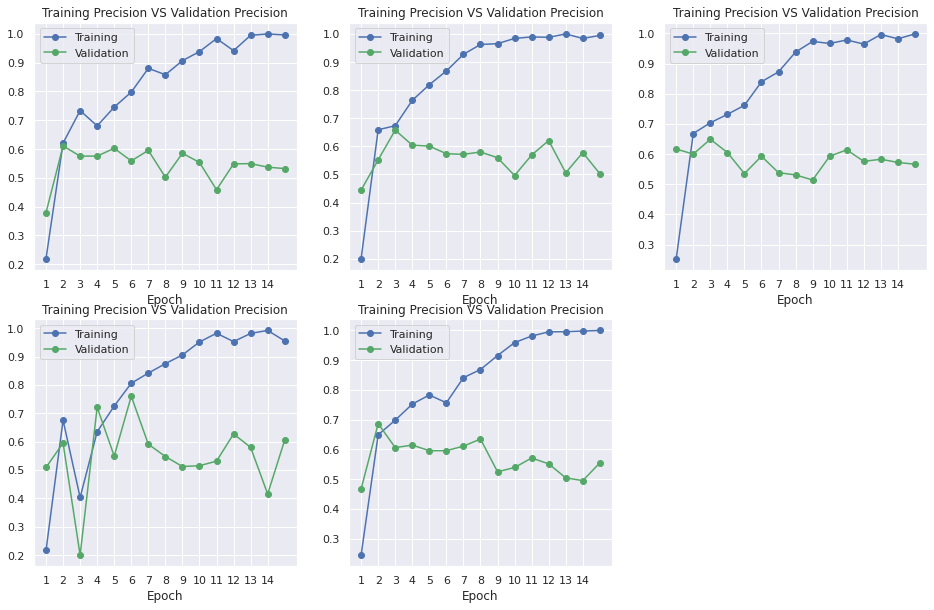

In [28]:
plot_learning_curve(stats, 'Training Precision', 'Validation Precision')

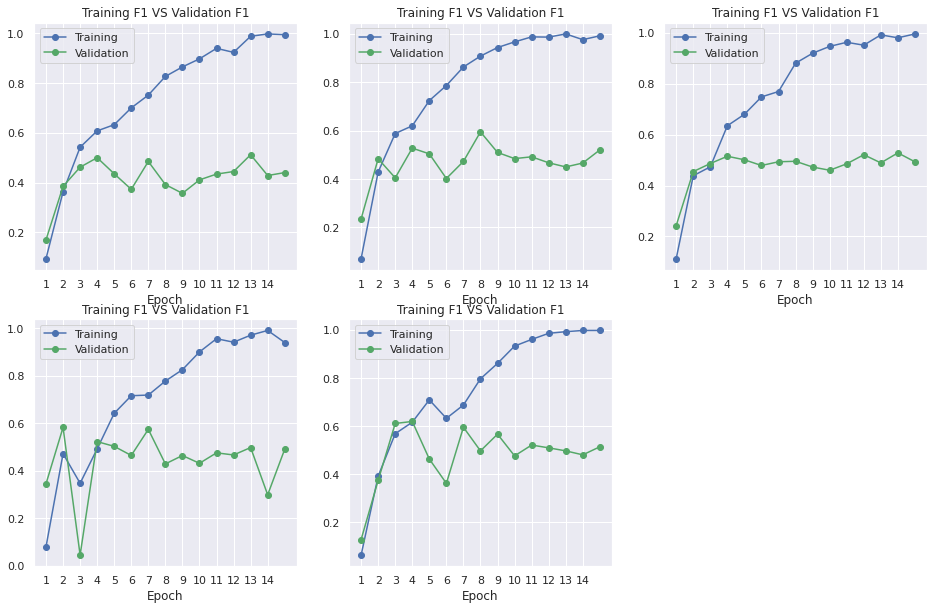

In [29]:
plot_learning_curve(stats, 'Training F1', 'Validation F1')

## Save model

In [30]:
print("Saving model to %s" % workdir_path)
torch.save(model.state_dict(), workdir_path+"buzzer_clf.pt")

Saving model to drive/My Drive/jakarta research/adi-buzzer/


## Testing data

In [31]:
epoch_test_loss, epoch_test_acc, epoch_test_pre, epoch_test_rec, epoch_test_f1, test_time = eval_model(model, test_dataloader)

print("\nTESTING")
print(f"Loss: {epoch_test_loss:.2f}  |  Accuracy: {epoch_test_acc:.2f}")
print(f"Precision: {epoch_test_pre:.2f}  |  Recall: {epoch_test_rec:.2f}  |  F1: {epoch_test_f1:.2f}")
print(f"Exec Time: {round(test_time)}s")

19it [00:03,  6.06it/s]


TESTING
Loss: 0.95  |  Accuracy: 0.80
Precision: 0.54  |  Recall: 0.47  |  F1: 0.49
Exec Time: 3s


In [32]:
test_dataloader.dataset.label.value_counts()

0    463
1    130
Name: buzzer, dtype: int64